In [1]:
# !pip install torch
# !pip install torchvision
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install scikit-learn

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import scipy
from torch.autograd import Variable

cudnn.benchmark = True
plt.ion()   # interactive mode

### Setting Seed

In [3]:
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

### Obtaining our datasets and dataloaders

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

### Implementing a Custom Triplet dataset for Flowers 102

In [6]:
from pathlib import Path
from typing import Any, Tuple, Callable, Optional
import random
import PIL.Image

class NewFlowers(torchvision.datasets.flowers102.Flowers102):
  def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
    super().__init__(root, split, transform, target_transform, download)
    self._labels = np.array(self._labels, dtype="int")
    
  def __getitem__(self, item):
    
    #obtain indexes of all the labels
    index = np.array(list(range(0, len(self._labels))), dtype="int")
    
    #obtain anchor image 
    anchor_img = self._image_files[item]
    anchor_img = PIL.Image.open(anchor_img).convert("RGB")
    
    #obtain anchor label
    anchor_label = self._labels[item]

    #generate positive index list where it is not the same class as the anchor
    positive_list = index[index!=item][self._labels[index!=item]==anchor_label]
    
    #randomly obtain 1 positive item and its respective image
    positive_item = random.choice(positive_list)
    positive_img = self._image_files[positive_item]
    positive_img = PIL.Image.open(positive_img).convert("RGB")

    #generate negative index list where it is not the same class as the anchor
    negative_list = index[index!=item][self._labels[index!=item]!=anchor_label]
    
    #randomly obtain 1 negative item and its respective image
    negative_item = random.choice(negative_list)
    negative_img = self._image_files[negative_item]
    negative_img = PIL.Image.open(negative_img).convert("RGB")

    #apply transformation on images
    anchor_img = self.transform(anchor_img)
    positive_img = self.transform(positive_img)
    negative_img = self.transform(negative_img)

    return (anchor_img, positive_img, negative_img), anchor_label

In [7]:
triplet_train = NewFlowers("./data/train", split="train", download=True, transform=data_transforms["train"])
triplet_val = NewFlowers("./data/train", split="val", download=True, transform=data_transforms["val"])
triplet_test = NewFlowers("./data/train", split="test", download=True, transform=data_transforms["test"])

In [8]:
triplet_train_dataloader = torch.utils.data.DataLoader(triplet_train, batch_size=4, shuffle=True)
triplet_val_dataloader = torch.utils.data.DataLoader(triplet_val, batch_size=4, shuffle=True)
triplet_test_dataloader = torch.utils.data.DataLoader(triplet_test, batch_size=4, shuffle=True)

In [9]:
image_datasets = {
    'train': triplet_train,
    'val': triplet_val,
    'test': triplet_test
}


dataloaders = {
    "train": triplet_train_dataloader,
    "val": triplet_val_dataloader,
    "test": triplet_test_dataloader,
}

dataset_sizes = {
        x: len(dataloaders[x].dataset)
        for x in list(image_datasets.keys())
    }

In [10]:
dataset_sizes

{'train': 1020, 'val': 1020, 'test': 6149}

### Function to visualise images

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Testing our triplet dataset

In [12]:
anchor, positive, negative = 0,0,0
for i, (inputs, labels) in enumerate(triplet_train_dataloader):
#     print(labels)
    anchor, positive, negative = inputs
    break

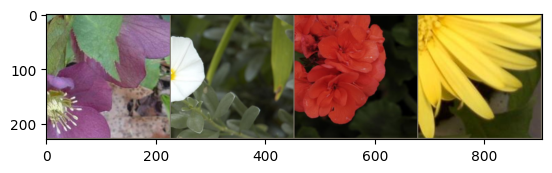

In [13]:
anchor_out = torchvision.utils.make_grid(anchor)
imshow(anchor_out)

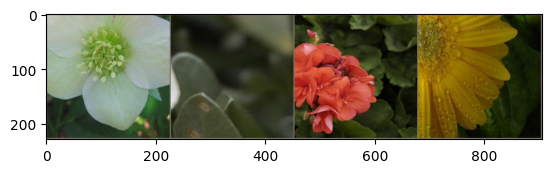

In [14]:
positive_out = torchvision.utils.make_grid(positive)
imshow(positive_out)

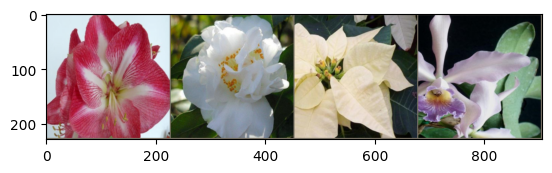

In [15]:
negative_out = torchvision.utils.make_grid(negative)
imshow(negative_out)

### General function to train the model (utilising both triplet loss & cross entropy loss)

In [16]:
import os
import torch
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Force synchronous CUDA execution

def train_model(model, optimizer, criterion, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()
    
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    crossEntropyLoss = torch.nn.CrossEntropyLoss()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for step, (inputs, anchor_label) in enumerate(dataloaders[phase]):
                anchor_img, positive_img, negative_img = inputs
                anchor_img, positive_img, negative_img = anchor_img.to(device), positive_img.to(device), negative_img.to(device)
                anchor_label = anchor_label.to(device).long()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    anchor_out = model(anchor_img)
                    positive_out = model(positive_img)
                    negative_out = model(negative_img)

                    _, preds = torch.max(anchor_out, 1)
                    triplet_loss = criterion(anchor_out, positive_out, negative_out)
                    celoss = crossEntropyLoss(anchor_out, anchor_label)
                    loss = triplet_loss + celoss

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                loss_value = loss.item()
                running_loss += loss_value * len(anchor_label)
                running_corrects += torch.sum(preds == anchor_label).item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy: {best_acc:.4f}')

    return model, train_loss, train_acc, val_loss, val_acc


### Function to plot train & val accuracy/loss

In [17]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

### Transfer learning with freezing (transformer vit_b_16)

In [18]:
model_path = './model_checkpoints/transformer_vit_b_16_freeze_TripletLoss_CrossEntropyLoss_GPU.pt'

check_file = os.path.exists(model_path)
if check_file:
    print(f"Loading model from checkpoint")
    loaded_transformer = torch.load(model_path)
    
else:
    print(f"Model checkpoint does not exist.\nDownloading new model...")
    model_conv = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')
    
    #freezing all other layers
    for param in model_conv.parameters():
        param.requires_grad = False
        
    num_ftrs = model_conv.heads.head.in_features
    model_conv.heads.head = nn.Linear(num_ftrs, 102)

Model checkpoint does not exist.


In [19]:
print(model_conv)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [20]:
num_epochs = 40

model_conv = model_conv.to(device)

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.heads.head.parameters(), lr=0.001, momentum=0.9)

criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.1)

In [21]:
model_conv, train_loss, train_acc, val_loss, val_acc = train_model(model_conv, optimizer_conv, criterion, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=num_epochs)

Using device: cuda
Epoch 1/40
----------


C:\Users\Arnav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


train Loss: 4.5045 Acc: 0.1118
val Loss: 3.5485 Acc: 0.3902

Epoch 2/40
----------
train Loss: 3.1141 Acc: 0.4961
val Loss: 2.6450 Acc: 0.6353

Epoch 3/40
----------
train Loss: 2.3509 Acc: 0.6853
val Loss: 2.1276 Acc: 0.6931

Epoch 4/40
----------
train Loss: 1.8142 Acc: 0.7990
val Loss: 1.7856 Acc: 0.7647

Epoch 5/40
----------
train Loss: 1.5096 Acc: 0.8520
val Loss: 1.5825 Acc: 0.8108

Epoch 6/40
----------
train Loss: 1.2869 Acc: 0.8824
val Loss: 1.4268 Acc: 0.8098

Epoch 7/40
----------
train Loss: 1.1214 Acc: 0.9118
val Loss: 1.2911 Acc: 0.8333

Epoch 8/40
----------
train Loss: 1.0346 Acc: 0.9029
val Loss: 1.2219 Acc: 0.8549

Epoch 9/40
----------
train Loss: 0.8673 Acc: 0.9333
val Loss: 1.1308 Acc: 0.8510

Epoch 10/40
----------
train Loss: 0.8678 Acc: 0.9176
val Loss: 1.1709 Acc: 0.8569

Epoch 11/40
----------
train Loss: 0.7598 Acc: 0.9441
val Loss: 1.0439 Acc: 0.8657

Epoch 12/40
----------
train Loss: 0.7121 Acc: 0.9422
val Loss: 0.9737 Acc: 0.8716

Epoch 13/40
----------


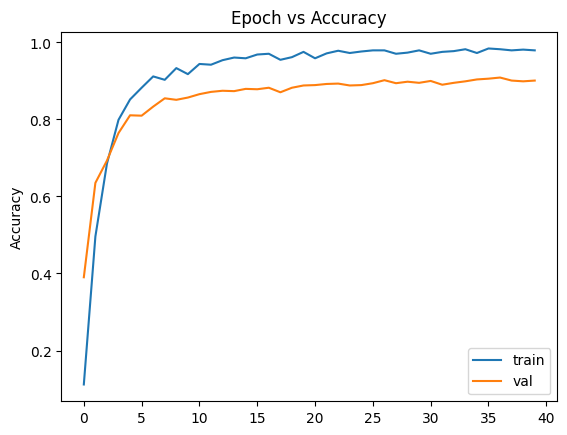

In [22]:
plot_graph(num_epochs, train_acc, val_acc, "Epoch vs Accuracy")

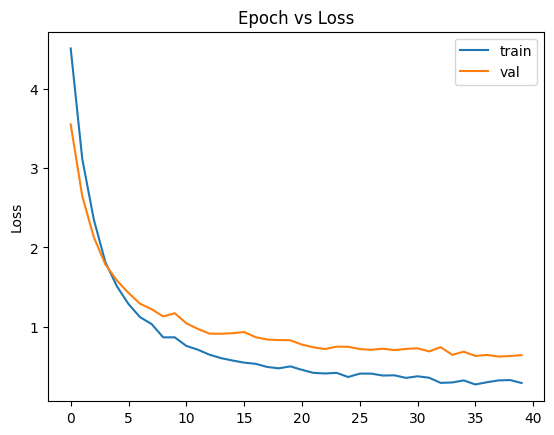

In [23]:
plot_graph(num_epochs, train_loss, val_loss, "Epoch vs Loss")

### Testing on test set

In [24]:
def test(model):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    size = len(dataloaders['test'].dataset)
    no_batches = len(dataloaders['test'])
    correct = 0
    with torch.no_grad():
        for i, (inputs, anchor_label) in enumerate(dataloaders['test']):

            anchor_label = anchor_label.to(device)
            
            anchor_img, _, _ = inputs
            anchor_img = anchor_img.to(device)
            
        
            anchor_out = model(anchor_img)

            _, preds = torch.max(anchor_out, 1)

            preds = preds.to(device)

            correct += torch.sum(preds == anchor_label.data)
            if i % 20 == 0:
                print(f'Predicted: {preds[0]} | True: {anchor_label[0]}')

    correct = correct.double() / size
    model.train(mode=was_training)
    return correct

In [25]:
test_acc = test(model_conv)

Predicted: 93 | True: 93
Predicted: 40 | True: 40
Predicted: 49 | True: 49
Predicted: 88 | True: 88
Predicted: 76 | True: 76
Predicted: 73 | True: 73
Predicted: 88 | True: 88
Predicted: 41 | True: 41
Predicted: 6 | True: 6
Predicted: 90 | True: 90
Predicted: 11 | True: 11
Predicted: 97 | True: 97
Predicted: 81 | True: 81
Predicted: 91 | True: 91
Predicted: 96 | True: 96
Predicted: 69 | True: 61
Predicted: 17 | True: 17
Predicted: 59 | True: 59
Predicted: 83 | True: 77
Predicted: 45 | True: 45
Predicted: 73 | True: 73
Predicted: 50 | True: 50
Predicted: 45 | True: 45
Predicted: 87 | True: 93
Predicted: 100 | True: 100
Predicted: 72 | True: 72
Predicted: 83 | True: 83
Predicted: 39 | True: 39
Predicted: 93 | True: 93
Predicted: 94 | True: 94
Predicted: 85 | True: 85
Predicted: 69 | True: 81
Predicted: 86 | True: 86
Predicted: 73 | True: 73
Predicted: 51 | True: 51
Predicted: 80 | True: 80
Predicted: 74 | True: 74
Predicted: 27 | True: 27
Predicted: 50 | True: 50
Predicted: 20 | True: 20


In [26]:
print(f"Test Acc: {test_acc}")

Test Acc: 0.89087656529517
